In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from quantum_code import *
from classical_code import *
import stim
from scipy.sparse import lil_matrix
from tqdm import tqdm
from ldpc import bposd_decoder, bp_decoder
# %load_ext snakeviz

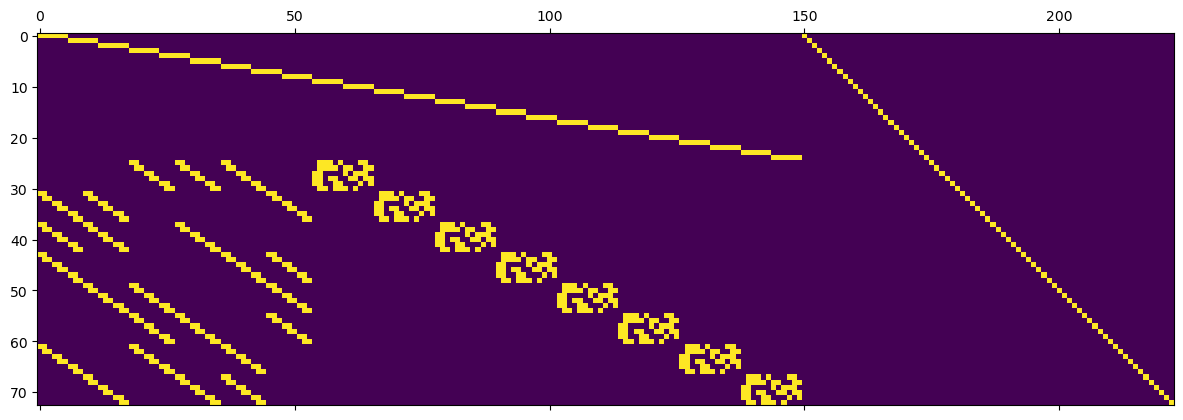

In [2]:
qcode = read_qcode("../codes/qcodes/HGP_100_4.qcode")
qcode = read_qcode("../codes/qcodes/HGP_C642_150_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_200_4.qcode")
# qcode = read_qcode("./codes/qcodes/HGP_C752_140_4.qcode")


# qcode = read_qcode("../codes/qcodes/HGP_400_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C642_1350_36.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_1600_64.qcode")


# qcode = read_qcode("./codes/qcodes/HGP_C642_600_16.qcode")
# qcode = read_qcode("./codes/qcodes/HGP_C422_800_16.qcode")

# qcode = read_qcode("./codes/qcodes/HGP_Surface_1300_4.qcode")

Hx, Hz, Lx, Lz = qcode.to_numpy()

aug_Hx = np.hstack([Hx, np.eye(Hx.shape[0], dtype=int)])
aug_Hz = np.hstack([Hz, np.eye(Hz.shape[0], dtype=int)])


plt.matshow(aug_Hz)

In [3]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

In [4]:
cn = qcode.n
cmx = qcode.xm
cmz = qcode.zm
# qedm, qedn = concatenatedStabilizersQED.shape
# qecm, qecn = concatenatedStabilizersXQEC.shape
data_qbts = np.arange(cn)
x_checks = np.arange(cn,cn+cmx)
z_checks = np.arange(cn+cmx,cn+cmx+cmz)
all_qbts = np.arange(cn+cmx+cmz)

precomputed_x_checks_circuits = np.empty(cmx, dtype=object)
for x in np.arange(qcode.xm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hx[x])[0]]
    for qbt in gen_qbts:
        path_qbts = [x_checks[x], qbt]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, 1e-3)
    precomputed_x_checks_circuits[x] = c

def prepare_x_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], 1e-3)
    for x in checks:
        c += precomputed_x_checks_circuits[x]
    c.append("H", [x_checks[x_check] for x_check in checks])
    c.append("DEPOLARIZE1", [x_checks[x_check] for x_check in checks], 1e-3)
    return c

precomputed_z_checks_circuits = np.empty(cmz, dtype=object)
for z in np.arange(qcode.zm):
    c = stim.Circuit()
    gen_qbts = data_qbts[np.where(Hz[z])[0]]
    for qbt in gen_qbts:
        path_qbts = [qbt, z_checks[z]]
        c.append("CNOT", path_qbts)
        c.append("DEPOLARIZE2", path_qbts, 1e-3)
    precomputed_z_checks_circuits[z] = c

def prepare_z_checks(checks):
    c = stim.Circuit()
    if len(checks) == 0: return c
    for z in checks:
        c += precomputed_z_checks_circuits[z]
    return c

In [5]:
qubit_error_rate = 0.01
meas_error_rate = 0.01

if (qcode.qedzm):
    bp_qed_dec = bp_decoder(
        aug_Hz[:qcode.qedxm], # the parity check matrix
        error_rate=qubit_error_rate,
        # channel_probs=new_channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
        max_iter=100, #pcm.shape[1], #the maximum number of iterations for BP)
        bp_method="msl",
        ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
        # osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
        # osd_order=40 #the osd search depth
    )

bposd_qed_qec_dec = bposd_decoder(
    aug_Hz,
    error_rate=qubit_error_rate,
    bp_method="msl",
    max_iter=Hz.shape[1],
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=40 #the osd search depth
)

bposd_qec_dec = bposd_decoder(
    aug_Hz,
    error_rate=qubit_error_rate,
    # channel_probs=Hx.shape[1]*[qubit_error_rate],
    bp_method="msl",
    max_iter=Hz.shape[1],
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=4 #the osd search depth
)


def decode(curr_synd, concat):
    guessed_error = np.zeros(Hx.shape[1], dtype=int)

    if (concat == 0):
        # QEC only
        guessed_error = bposd_qec_dec.decode(curr_synd)
    elif (concat == 1):
        # QED + QEC
        _ = bp_qed_dec.decode(curr_synd[:qcode.qedxm])

        ######################## # THIS MIGHT NEED TO CHANGE SLIGHTLY, SOFT INFORMATION DECODING
        # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios)
        new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
        new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
        bposd_qed_qec_dec.update_channel_probs(new_channel_probs)
        ########################

        guessed_error = bposd_qed_qec_dec.decode(curr_synd)

    return guessed_error

In [351]:
np.random.seed(0)
for i in range(10):
    new_qubit_error = np.random.choice([0, 1], size=Hz.shape[1]-Hz.shape[0], p=[1-qubit_error_rate, qubit_error_rate])
    print(np.where(new_qubit_error))


(array([], dtype=int64),)
(array([72], dtype=int64),)
(array([56], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([36, 66], dtype=int64),)
(array([16], dtype=int64),)
(array([56], dtype=int64),)
(array([3], dtype=int64),)
(array([73], dtype=int64),)


In [363]:
class Simulation:
    def __init__(self, num_rounds, stab_type, concat=True, adaptive=True):
        self.num_rounds = num_rounds
        self.stab_type = stab_type
        self.curr_round = 1
        self.concat = concat
        self.adaptive = adaptive

        self.z_check_history = np.ones(cmz, dtype=int)
        self.x_check_history = np.ones(cmx, dtype=int)
        self.z_syndrome_history = np.zeros(shape=(num_rounds+3, cmz), dtype=int)
        self.x_syndrome_history = np.zeros(shape=(num_rounds+3, cmx), dtype=int)
        self.z_observables = np.zeros(qcode.k, dtype=int)
        self.x_observables = np.zeros(qcode.k, dtype=int)

        self.c = stim.Circuit()
        self.s = stim.TableauSimulator()

        if self.stab_type:
            self.c.append("H", [qbt for qbt in data_qbts])
            self.c += prepare_z_checks(np.arange(cmz)).without_noise()
            # self.c.append("X_ERROR", z_checks, 1e-4)
            for i, z_check in enumerate(np.arange(cmz)):
                self.c.append("MR", z_checks[z_check])
            # self.c.append("X_ERROR", z_checks, 1e-5)
        else:
            self.c += prepare_x_checks(np.arange(cmx)).without_noise()
            # self.c.append("X_ERROR", x_checks, 1e-4)
            for i, x_check in enumerate(np.arange(cmx)):
                self.c.append("MR", x_checks[x_check])
            # self.c.append("X_ERROR", x_checks, 1e-5)

        self.s.do_circuit(self.c)
        if self.stab_type:
            self.z_syndrome_history[0] = self.s.current_measurement_record()
        else:
            self.x_syndrome_history[0] = self.s.current_measurement_record()


    def QED(self):
        def measure_z_qed_checks(c):
            c += prepare_z_checks(np.arange(qcode.qedzm)).without_noise()
            c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)], 1e-2)
            for i, z_check in enumerate(np.arange(qcode.qedzm)):
                c.append("MR", z_checks[z_check])
            # c.append("X_ERROR", [z_checks[z_check] for z_check in np.arange(qcode.qedzm)], 1e-3)
            return c

        def measure_x_qed_checks(c):
            c += prepare_x_checks(np.arange(qcode.qedxm)).without_noise()
            c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)], 1e-2)
            for i, x_check in enumerate(np.arange(qcode.qedxm)):
                c.append("MR", x_checks[x_check])
            # c.append("X_ERROR", [x_checks[x_check] for x_check in np.arange(qcode.qedxm)], 1e-3)
            return c

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qed_checks(c)
            c = measure_z_qed_checks(c)
        else:
            c = measure_z_qed_checks(c)
            c = measure_x_qed_checks(c)
        return c

    def QEC(self):
        def measure_z_qec_checks(c, curr_z_checks):
            c += prepare_z_checks(curr_z_checks).without_noise()
            c.append("X_ERROR", [z_checks[z_check] for z_check in curr_z_checks], 1e-2)
            for i, z_check in enumerate(curr_z_checks):
                c.append("MR", z_checks[z_check])
            # c.append("X_ERROR", z_checks, 1e-3)
            return c

        def measure_x_qec_checks(c, curr_x_checks):
            c += prepare_x_checks(curr_x_checks).without_noise()
            c.append("X_ERROR", [x_checks[x_check] for x_check in curr_x_checks], 1e-2)
            for i, x_check in enumerate(curr_x_checks):
                c.append("MR", x_checks[x_check])
            # c.append("X_ERROR", x_checks, 1e-3)
            return c

        c = stim.Circuit()
        if self.stab_type:
            c = measure_x_qec_checks(c, self.curr_x_checks)
            c = measure_z_qec_checks(c, self.curr_z_checks)
        else:
            c = measure_z_qec_checks(c, self.curr_z_checks)
            c = measure_x_qec_checks(c, self.curr_x_checks)
        return c

    def final_synd_and_observables(self):
        self.curr_z_checks = np.arange(cmz)
        self.curr_x_checks = np.arange(cmx)
        confirmation_z = np.ones(cmz, dtype=int)
        confirmation_x = np.ones(cmx, dtype=int)
        self.z_check_history = np.vstack([self.z_check_history, confirmation_z])
        self.x_check_history = np.vstack([self.x_check_history, confirmation_x])

        QEC_circuit = self.QEC().without_noise()
        self.s.do_circuit(QEC_circuit)
        self.c += QEC_circuit

        meas = self.s.current_measurement_record()
        lookback = lambda x: -len(x) if len(x) else None

        if self.stab_type:
            pass
        else:
            if len(self.curr_z_checks):
                self.z_syndrome_history[self.curr_round][self.curr_z_checks] = meas[lookback(np.concatenate([self.curr_z_checks, self.curr_x_checks])):
                                                                        lookback(self.curr_x_checks)]
            if len(self.curr_x_checks):
                self.x_syndrome_history[self.curr_round][self.curr_x_checks] = meas[lookback(self.curr_x_checks):]

            guessed_error = decode(self.z_syndrome_history[self.curr_round], self.concat)
            self.s.x(*np.where(guessed_error)[0])

        ######################################
        c = stim.Circuit()

        if self.stab_type: self.c.append("H", [qbt for qbt in data_qbts])
        c.append("M", data_qbts)

        self.s.do_circuit(c)
        self.c += c

        meas = self.s.current_measurement_record()
        H = Hx if self.stab_type else Hz
        for i in range(H.shape[0]):
            incl_qbts = np.where(H[i])[0]
            incl_qbts = np.array([j-cn for j in incl_qbts])

            if self.stab_type:
                pass
            else:
                self.z_syndrome_history[-1][i] = np.sum(np.take(meas, incl_qbts)) % 2

        for i, logical in enumerate(Lx if self.stab_type else Lz):
            incl_qbts = np.where(logical)[0]
            incl_qbts = [j-cn for j in incl_qbts]

            if self.stab_type:
                self.x_observables[i] = np.sum(np.take(meas, incl_qbts)) % 2
            else:
                self.z_observables[i] = np.sum(np.take(meas, incl_qbts)) % 2


    def simulate(self):
        # self.s.x(149)

        for _ in range(1, self.num_rounds+1):
            self.c.append("X_ERROR", data_qbts, 0.01)  # idle errors
            self.s.x_error(*data_qbts, p=0.01)

            if not self.adaptive:
                self.curr_z_checks = np.arange(cmz)
                self.curr_x_checks = np.arange(cmx)
            else:
                QED_circuit = self.QED()
                self.s.do_circuit(QED_circuit)
                self.c += QED_circuit

                # determining which of the QEC stabilizers to measure
                meas = self.s.current_measurement_record()
                self.z_syndrome_history[self.curr_round][:qcode.qedzm] = meas[-(qcode.qedzm+qcode.qedxm):-qcode.qedzm]
                self.x_syndrome_history[self.curr_round][:qcode.qedxm] = meas[-qcode.qedxm:]

                z_qed_synd_diff = self.z_syndrome_history[self.curr_round-1][:qcode.qedzm] ^ self.z_syndrome_history[self.curr_round][:qcode.qedzm]
                x_qed_synd_diff = self.x_syndrome_history[self.curr_round-1][:qcode.qedxm] ^ self.x_syndrome_history[self.curr_round][:qcode.qedxm]

                self.curr_z_checks = sorted(get_overlapping(z_qed_synd_diff, False))
                self.curr_x_checks = sorted(get_overlapping(x_qed_synd_diff, True))

            confirmation_z = np.concatenate([np.ones(qcode.qedzm, dtype=int), np.zeros(cmz-qcode.qedzm, dtype=int)])
            confirmation_z[self.curr_z_checks] = 1
            confirmation_x = np.concatenate([np.ones(qcode.qedxm, dtype=int), np.zeros(cmx-qcode.qedxm, dtype=int)])
            confirmation_x[self.curr_x_checks] = 1
            self.z_check_history = np.vstack([self.z_check_history, confirmation_z])
            self.x_check_history = np.vstack([self.x_check_history, confirmation_x])

            QEC_circuit = self.QEC()
            self.s.do_circuit(QEC_circuit)
            self.c += QEC_circuit

            meas = self.s.current_measurement_record()
            lookback = lambda x: -len(x) if len(x) else None
            if self.stab_type:
                pass

                guessed_error = decode(self.x_syndrome_history[self.curr_round], self.concat)
                self.s.z(*np.where(guessed_error)[0])
            else:
                if len(self.curr_z_checks):
                    self.z_syndrome_history[self.curr_round][self.curr_z_checks] = meas[lookback(np.concatenate([self.curr_z_checks, self.curr_x_checks])):
                                                                          lookback(self.curr_x_checks)]
                if len(self.curr_x_checks):
                    self.x_syndrome_history[self.curr_round][self.curr_x_checks] = meas[lookback(self.curr_x_checks):]

                guessed_error = decode(self.z_syndrome_history[self.curr_round], self.concat)
                self.s.x(*np.where(guessed_error)[0])


            self.curr_round += 1

        self.final_synd_and_observables()

In [364]:
s = Simulation(1, stab_type=False, concat=False, adaptive=False)
s.simulate()
c = s.c

In [369]:
successes = 0
num_gens = []
for i in tqdm(range(1000)):
    s = Simulation(1, stab_type=False, concat=True, adaptive=True)
    s.simulate()
    c = s.c

    if np.any(s.z_observables): # or np.any(s.z_syndrome_history[-1]):
        pass
    else:
        successes += 1
print(successes)


100%|██████████| 1000/1000 [00:09<00:00, 104.49it/s]

929
